In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time
from tqdm import tqdm

import numpy as np
from scipy import linalg
from scipy import optimize
from scipy import sparse

import matplotlib.pyplot as plt

import plot_func as pf
import util_func as uf
import analyze_func as af

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2024-04-24 22:47:47.345090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


In [3]:
N4 = 60
n_inp = 50
n_cnd = 3
eta = 1e-2

In [4]:
from scipy.integrate import solve_ivp

def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_rec,gamma_ff,tau):
#     argE = gamma_rec * np.dot(Wrec[:N],y) + gamma_ff * inp_ff[0]
#     argI = gamma_rec * np.dot(Wrec[N:],y) + gamma_ff * inp_ff[1]
#     return 1./tau*( -y + fio_rect(np.concatenate([argE,argI])))
    arg = gamma_rec * np.dot(Wrec,y) + gamma_ff * inp_ff
    return 1./tau*( -y + fio_rect(arg))

def integrate(y0,inp,dt,Nt,Wrec,gamma_rec=1.02):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,Wrec,gamma_rec,1.0,1.0)
        dy = out
        y = y + dt*dy
    return np.array([y[:N4**2].reshape((N4,N4)),y[N4**2:].reshape((N4,N4))])
#     def ode_fun(t,y):
#         return dynamics_system(y,inp,Wrec,gamma_rec,1.0,N4*N4,1.0)
#     sol = solve_ivp(ode_fun,[0,dt*Nt],y0,method='RK23',first_step=dt)
#     return np.array([sol.y[:N4**2,-1].reshape((N4,N4)),sol.y[N4**2:,-1].reshape((N4,N4))])

In [5]:
x,y = np.meshgrid(np.linspace(-N4//2,N4//2-1,N4),np.linspace(-N4//2,N4//2-1,N4))
sig1 = 1.8*6/5
sig2 = 3.6*6/5
kern1 = 1./(np.sqrt(np.pi*2)*sig1)**2*np.exp((-x**2-y**2)/2./sig1**2)
kern2 = 1./(np.sqrt(np.pi*2)*sig2)**2*np.exp((-x**2-y**2)/2./sig2**2)
diff_gauss = kern1-kern2

In [6]:
inps = np.zeros((n_inp,2,N4,N4))

ring_image = np.fft.fft2(np.fft.fftshift(diff_gauss))

rng = np.random.default_rng(0)
for inp_idx in tqdm(range(n_inp)):
    for pop_idx in range(2):
        random_matrix = np.fft.fft2(rng.normal(size=(N4,N4)))
        ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
        inps[inp_idx,pop_idx,:,:] = 1 + eta*ring_ifft

init_rates = np.zeros((n_inp*n_cnd,2,N4,N4))
rng = np.random.default_rng(0)
for idx in tqdm(range(n_inp*n_cnd)):
    init_rates[idx,:,:] = np.fmax(0,rng.normal(0.5,0.1,size=(2,N4,N4)))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:00<00:00, 5757.45it/s]


# See if Unaligned E/I Connectivity can Support Modular Correlations

In [7]:
config_name = "big_hetero"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name,verbose=False)
    
W4 = connectivity.Connectivity_2pop((N4,N4),(N4,N4),\
                                    (N4,N4), (N4,N4),\
                                    random_seed=config_dict["random_seed"],\
                                    Nvert=1, verbose=True)

start = time.process_time()

Whtro,arbor4to4 = W4.create_matrix_2pop(config_dict["W4to4_params"],config_dict["W4to4_params"]["Wrec_mode"],
                                        I_seed_diff=100)

print('Creating heterogeneous recurrent connectivity took',time.process_time() - start,'s')
# np.save('hetero_W4to4_N4={:d}'.format(N4),Whtro)

# Whtro = np.load('hetero_W4to4_N4={:d}.npy'.format(N4))

{'sigma1': 0.08, 'sigma2': 0.15, 'ampl1': 1.0, 'ampl2': 1.0, 'sigma': 0.1, 'ampl': 1.0, 'noise': 0.0, 'sigma_EE': 0.02375, 'sigma_IE': 0.02375, 'sigma_EI': 0.0175, 'sigma_II': 0.0075, 'aEE': 22.2, 'aIE': 21.6, 'aEI': 21.6, 'aII': 20.8, 'rA_E': 0.13, 'rA_I': 0.13, 'r_lim': 1.0, 'Wrec_mode': 'Gaussian2pop', 'sigma_factor': 1.3333333333, 'max_ew': 1.0, 'density': 0.5, 'ncluster': 3, 'mean_eccentricity': 0.7, 'SD_eccentricity': 0.0175, 'SD_size': 0.0021, 'heterogeneity_type': 'independent', 'smoothness_width': 0.05, 'nu_4': 3.0, 'beta_P': 0.0005, 'Wlim': 12, 'learning_rate': 0.5, 'plasticity_rule': 'None', 'constraint_mode': 'None', 'mult_norm': 'None', 'firing_threshold': 'adaptive', 'theta_4': 0.9, 'l4_avg': 0.0}
profile_conn Gaussian
CHECK radius 0.13
arbor (60, 60, 60, 60)
CHECK radius 0.13
arbor (60, 60, 60, 60)
CHECK radius 0.13
arbor (60, 60, 60, 60)
CHECK radius 0.13
arbor (60, 60, 60, 60)

CHECK CONN VALS Gaussian 0.7511514060382335 0.7308500166858489 1.3946539267042053 8.44500418

Text(0.5, 1.0, 'L2/3 I Cell (Pre)')

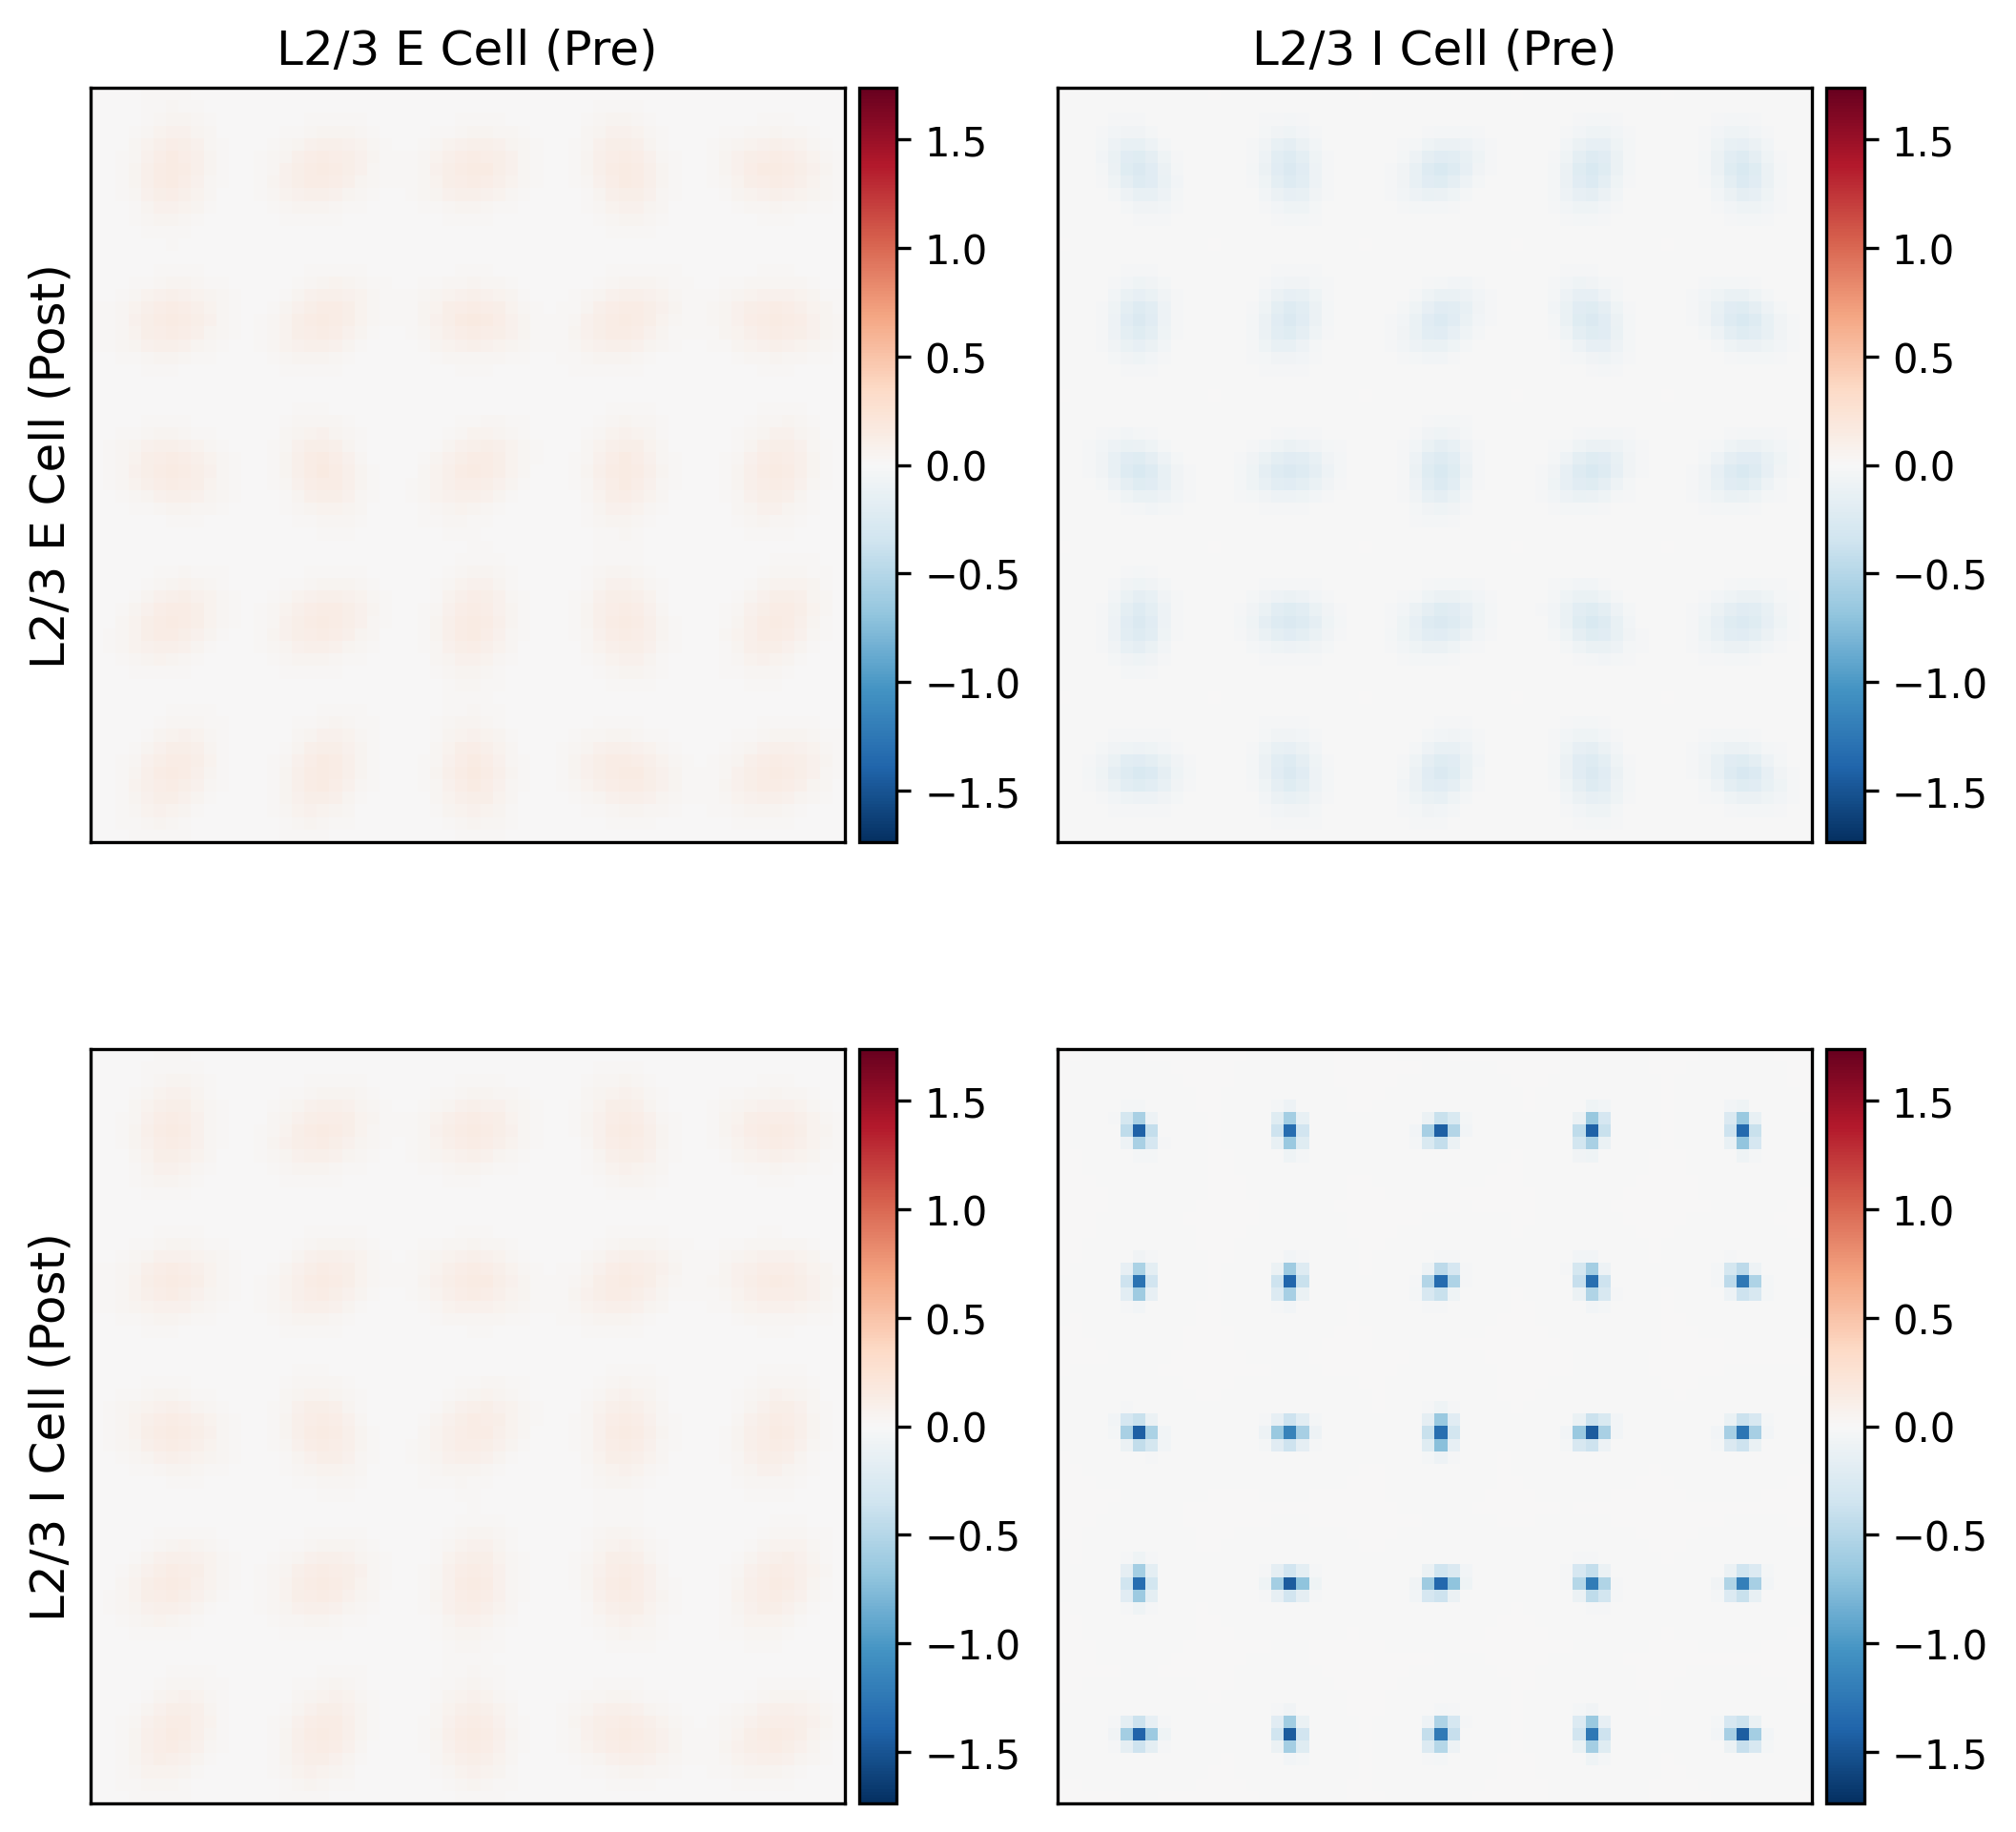

In [8]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4,N4))
WEI = np.zeros((N4,N4))
WIE = np.zeros((N4,N4))
WII = np.zeros((N4,N4))

idxs = np.arange(N4//10,N4,N4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4,N4))
        WEE += Whtro[:N4**2,:N4**2][:,rav_idx].reshape(N4,N4)
        WEI += Whtro[:N4**2,N4**2:][:,rav_idx].reshape(N4,N4)
        WIE += Whtro[N4**2:,:N4**2][:,rav_idx].reshape(N4,N4)
        WII += Whtro[N4**2:,N4**2:][:,rav_idx].reshape(N4,N4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')

axs[0,0].set_ylabel('L2/3 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L2/3 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L2/3 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L2/3 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(Whtro,1,which='LR')
# print(eigval)

# Construct Bandpass Filtered Inputs

In [9]:
rates = np.zeros((n_inp*n_cnd,2,N4,N4))

start = time.process_time()

for inp_idx in tqdm(range(n_inp)):
        for cnd_idx in tqdm(range(n_cnd), leave=False):
            idx = inp_idx*n_cnd+cnd_idx
            rates[idx] = integrate(init_rates[idx].flatten(),inps[inp_idx].flatten(),1/3,2000,Whtro)
    
print('Simulating rate dynamics took',time.process_time() - start,'s')
np.save('hetero_misalign_rates_N4={:d}'.format(N4),rates.flatten())

100%|██████████| 50/50 [3:51:58<00:00, 278.38s/it]  


Simulating rate dynamics took 43858.868314 s


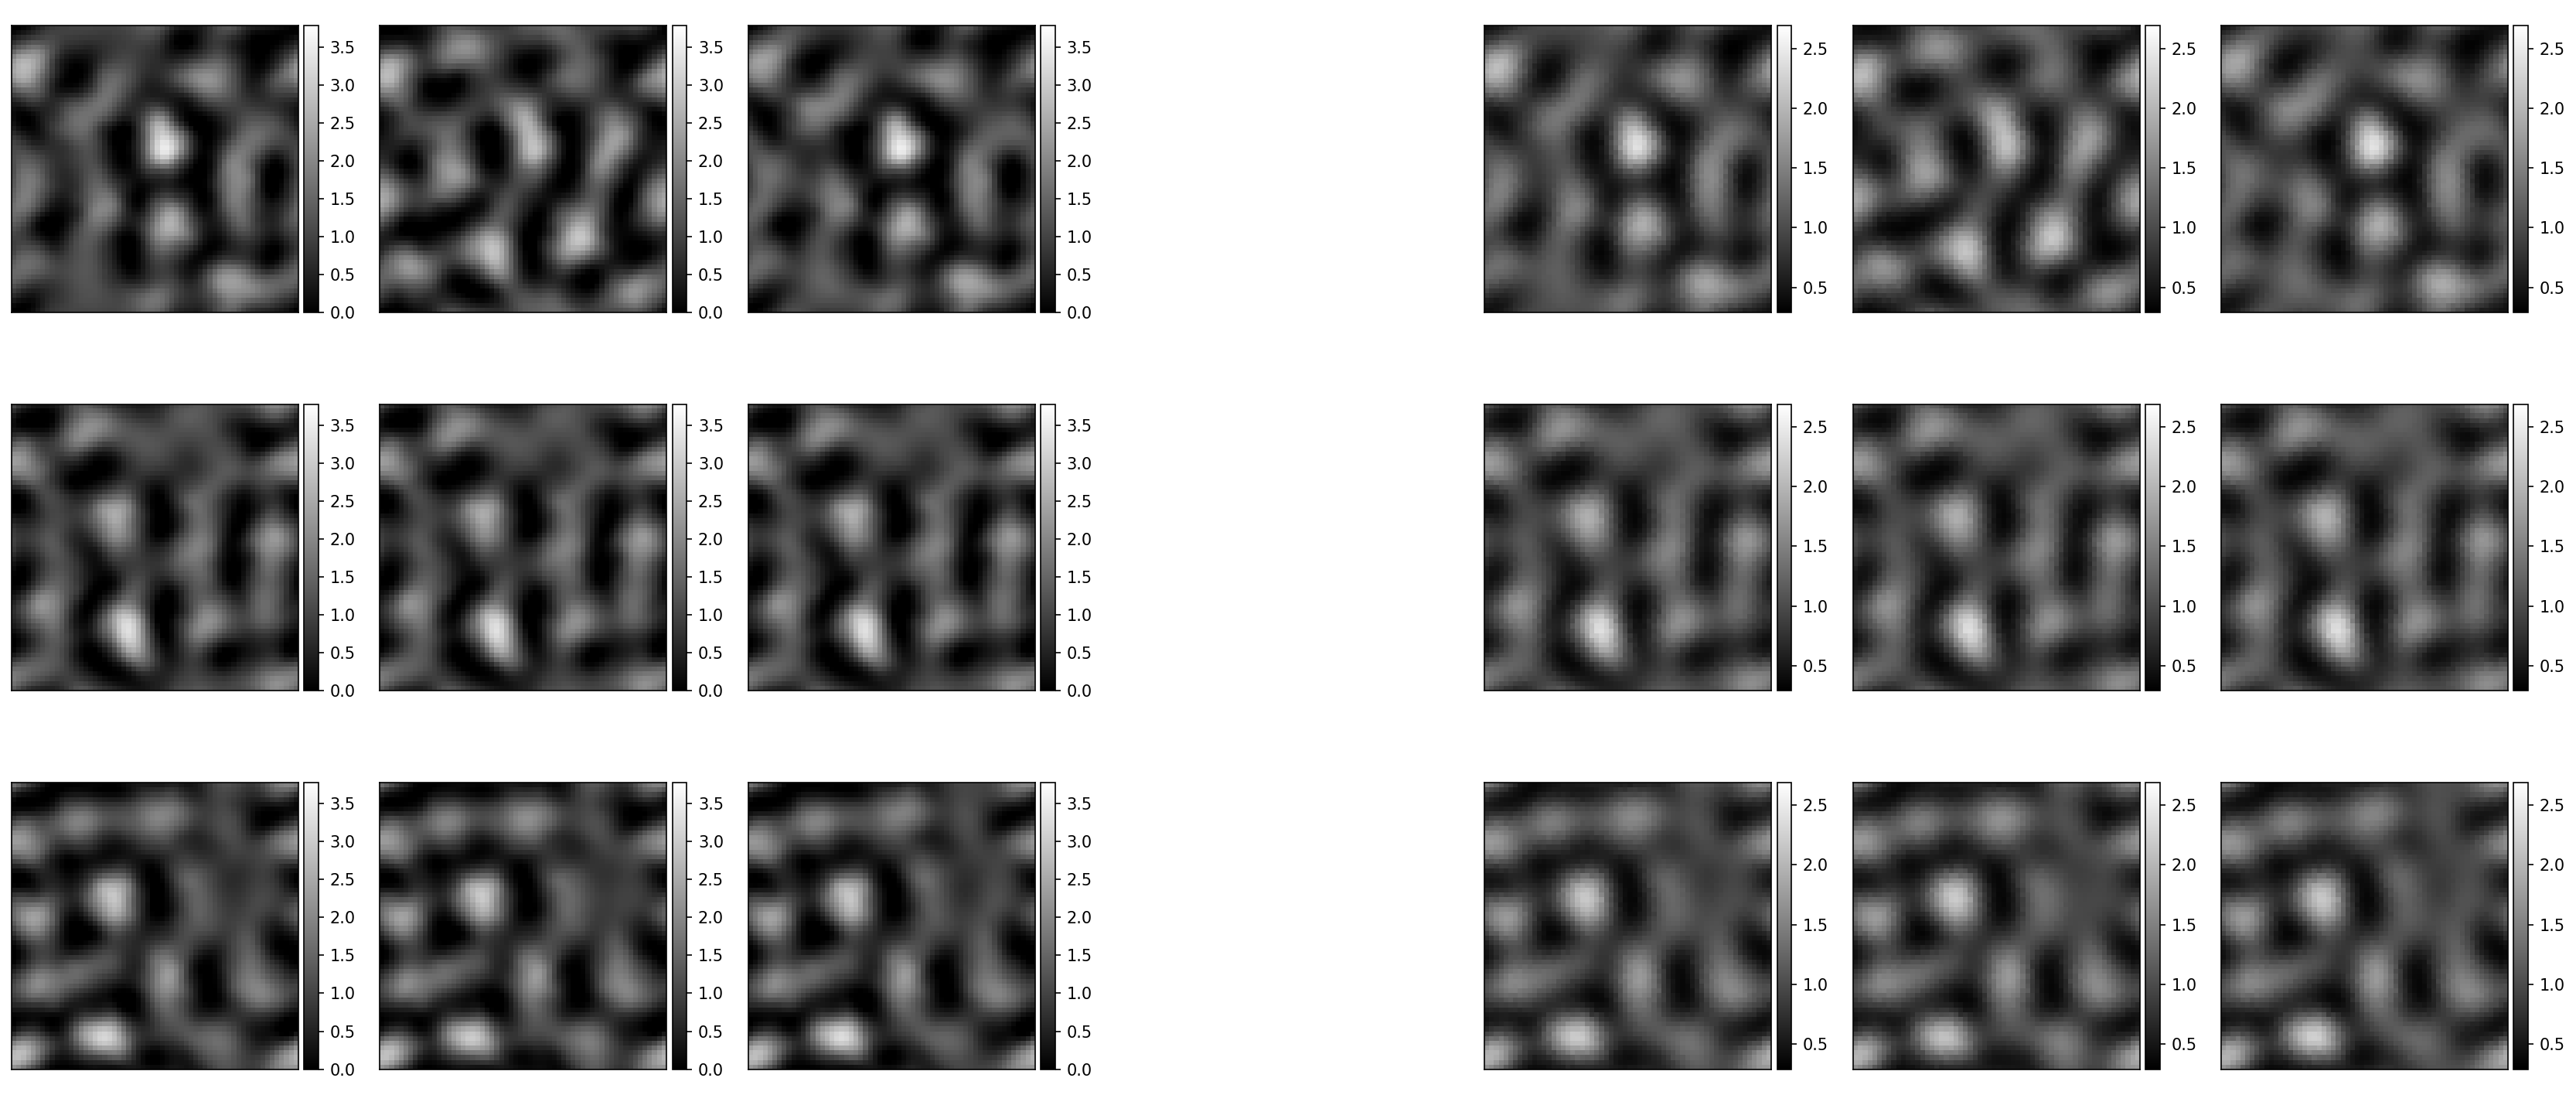

In [10]:
n_row = 3

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*4,n_row*4),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     rates[idx,0],cmap='binary_r',
                     vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     rates[idx,1],cmap='binary_r',
                     vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

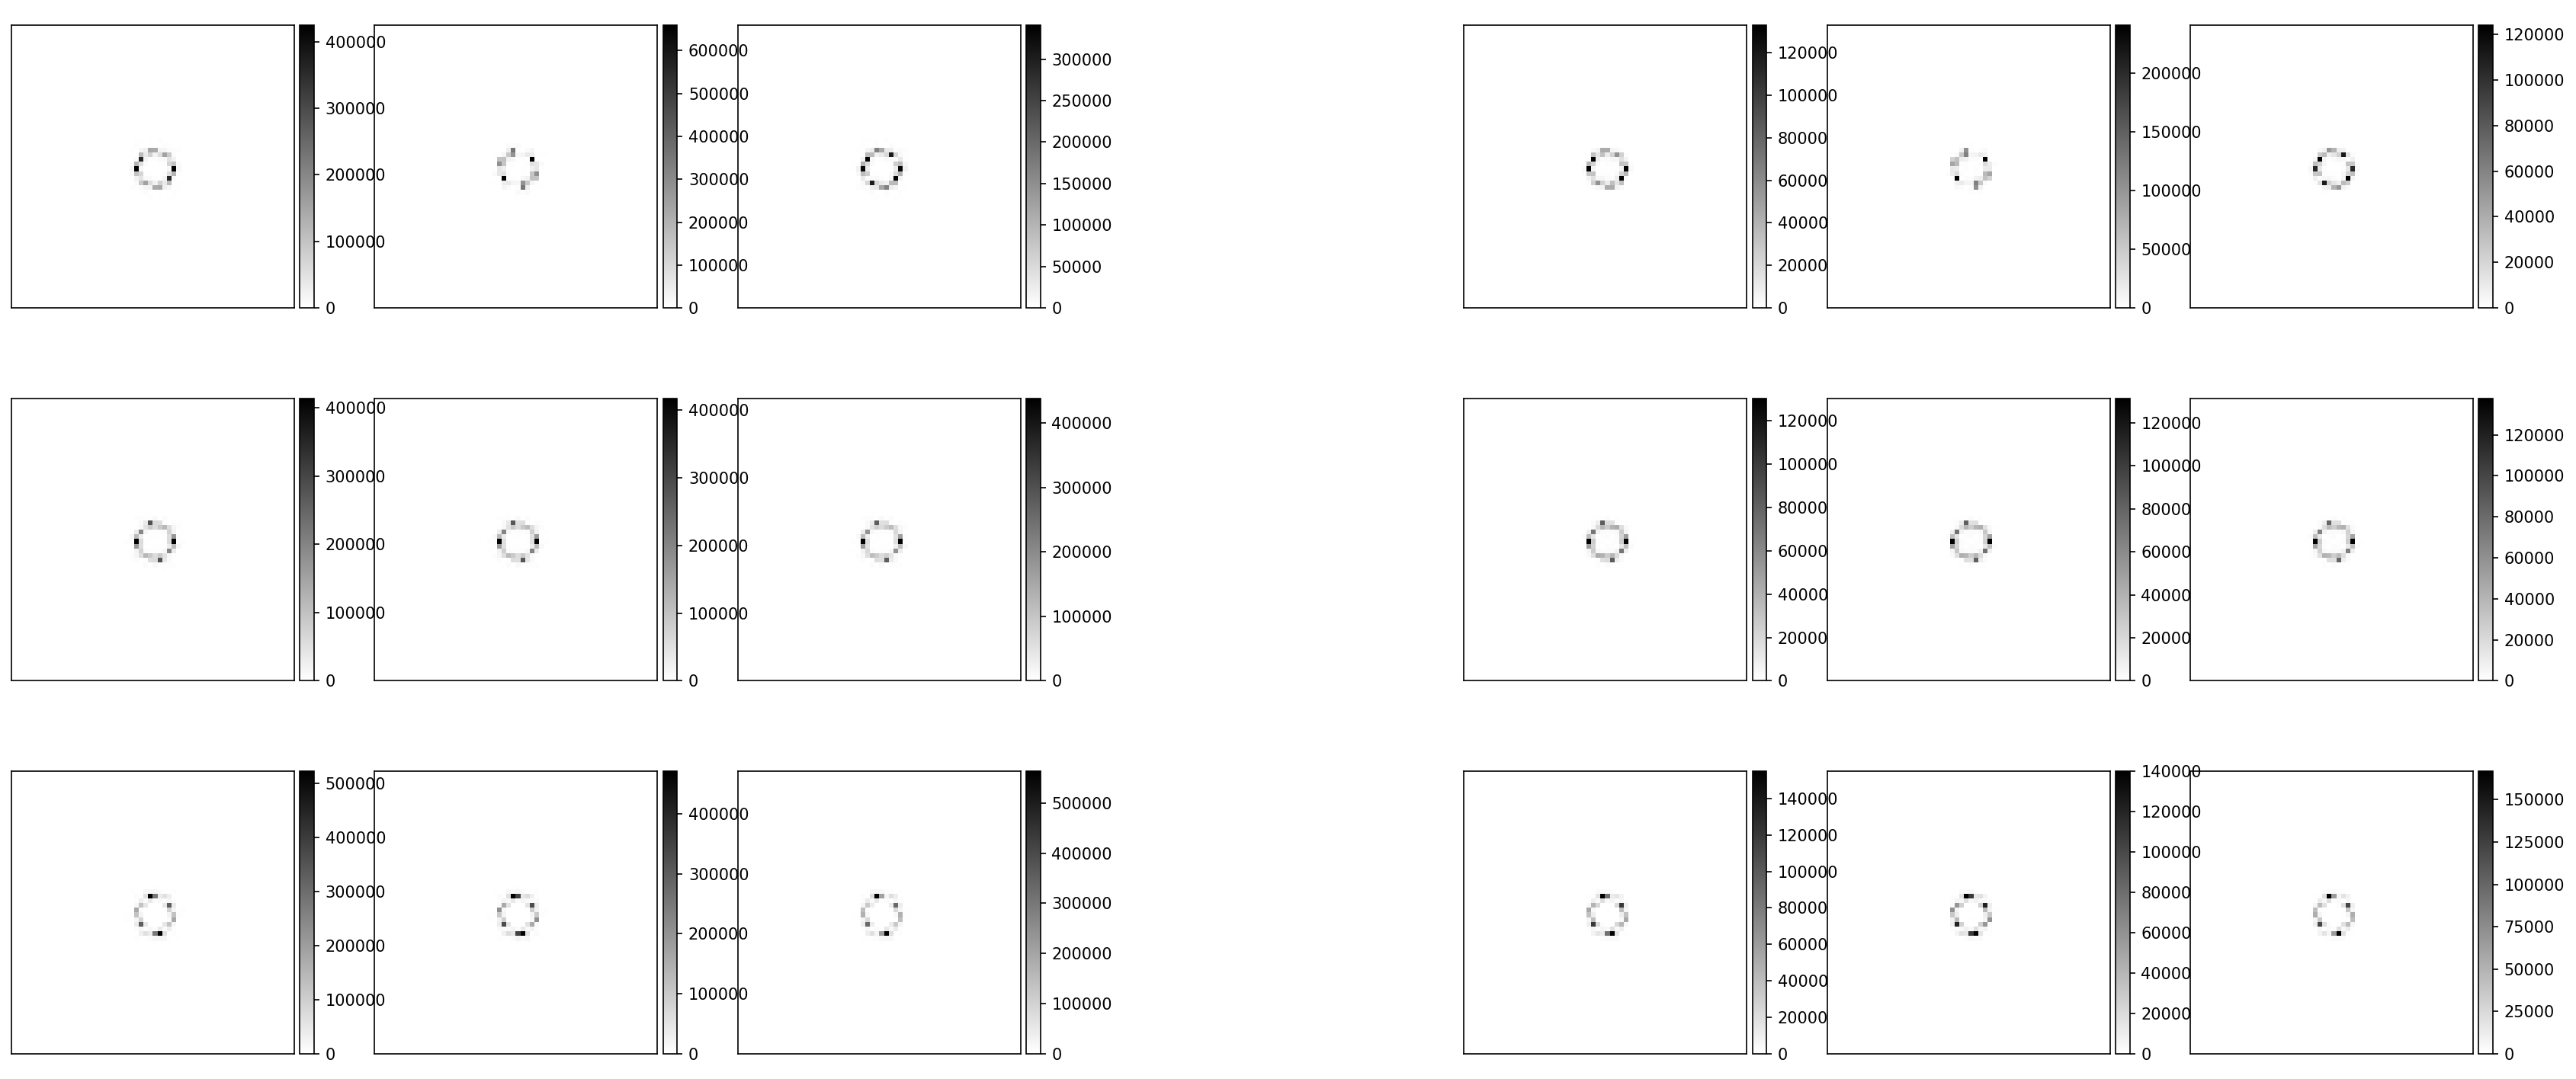

In [11]:
n_row = 3

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*4,n_row*4),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2,
                     cmap='binary')
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2,
                     cmap='binary')

In [12]:
rates_zsc = rates[:,0] - np.mean(rates[:,0],0)
rates_zsc = rates_zsc / np.std(rates[:,0],0)

start = time.process_time()

# rates_cov = np.einsum('ijk,ilm->jklm',rates_sub,rates_sub) / n_inp
# rates_corr = rates_cov/(rates_std[:,:,None,None]*rates_std[None,None,:,:])
rates_corr = np.einsum('ijk,ilm->jklm',rates_zsc,rates_zsc) / (n_inp*n_cnd)

print('Calculating correlation patterns took',time.process_time() - start,'s')

Calculating correlation patterns took 5.554875999994692 s


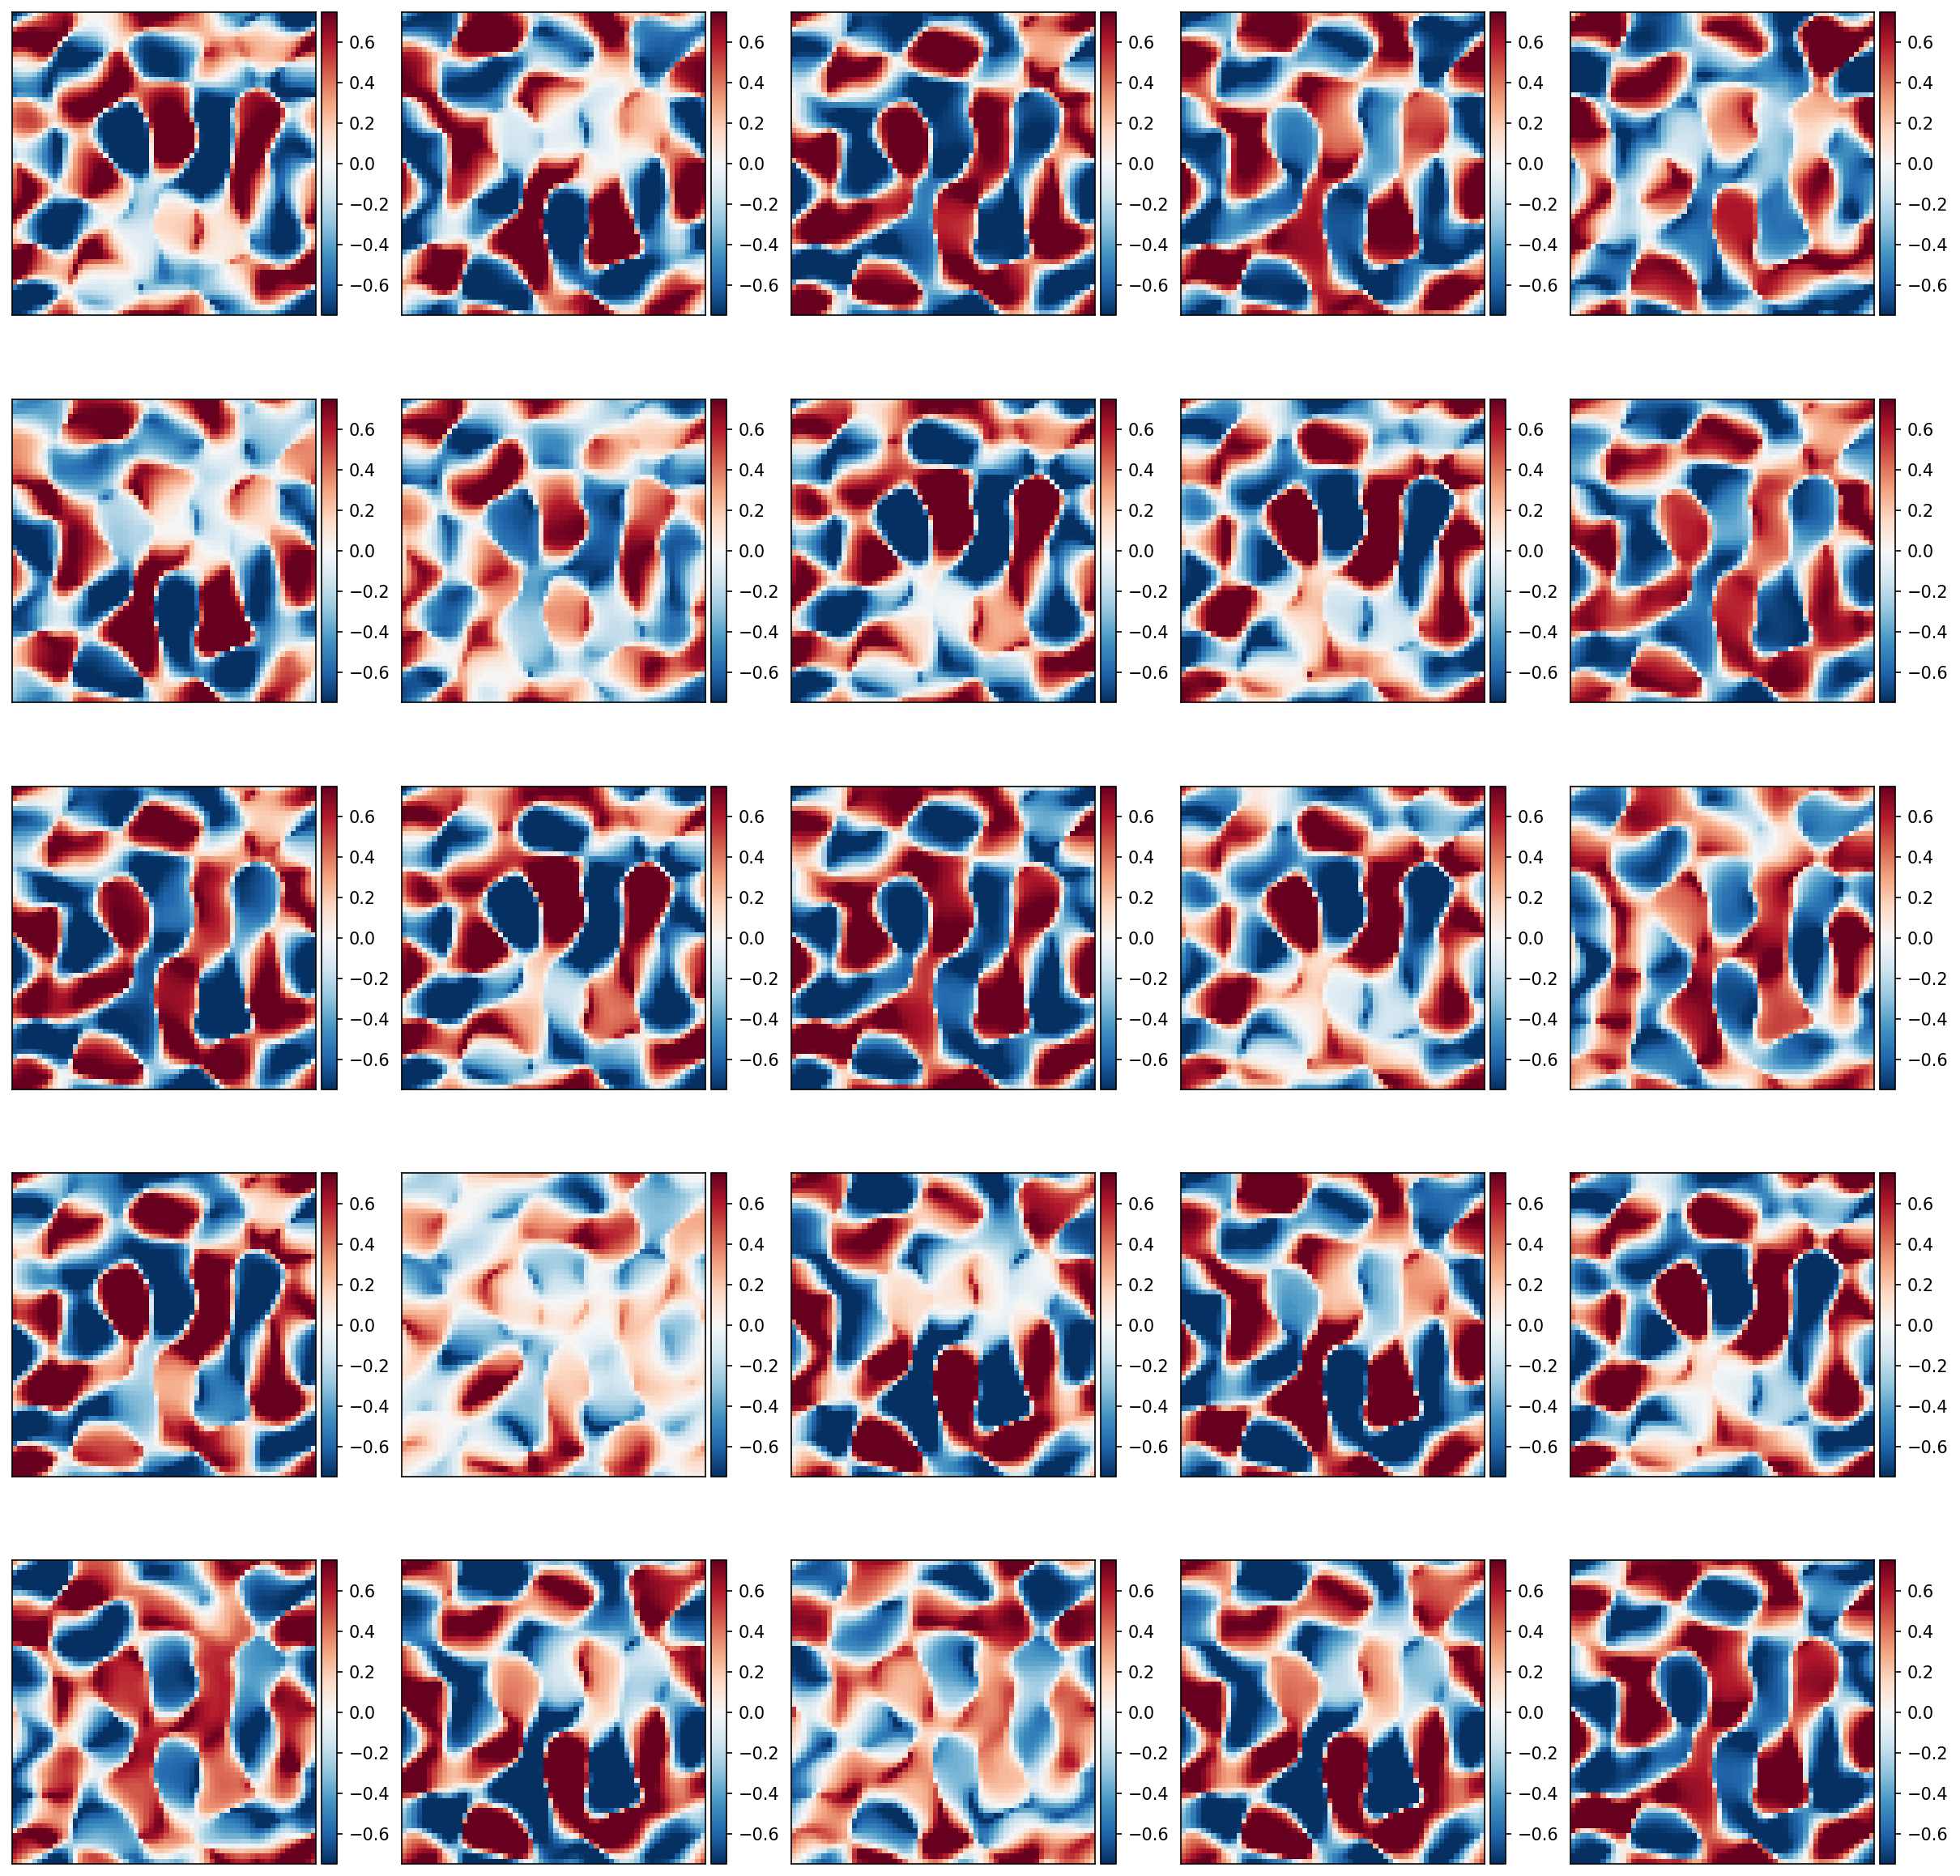

In [13]:
n_row = 5

fig,axs = plt.subplots(n_row,n_row,figsize=(n_row*4,n_row*4),dpi=150)

idxs = np.arange(N4//(2*n_row),N4,N4//n_row)
for i in range(n_row):
    for j in range(n_row):
        seed_idx = (idxs[i],idxs[j])
        corr_patt = rates_corr[seed_idx[0],seed_idx[1],:,:]
        pf.imshowbar(fig,axs[i,j],corr_patt,cmap='RdBu_r',vmin=-0.75,vmax=0.75)

In [15]:
loc_max = rates_corr[:,:,:,:] > np.roll(rates_corr[:,:,:,:],-1,2)
loc_max = np.logical_and(loc_max,rates_corr[:,:,:,:] > np.roll(rates_corr[:,:,:,:],1,2))
loc_max = np.logical_and(loc_max,rates_corr[:,:,:,:] > np.roll(rates_corr[:,:,:,:],-1,3))
loc_max = np.logical_and(loc_max,rates_corr[:,:,:,:] > np.roll(rates_corr[:,:,:,:],1,3))

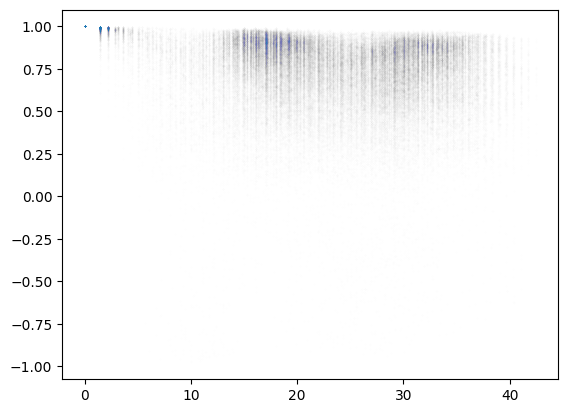

In [16]:
dxs,dys = np.meshgrid(np.arange(N4),np.arange(N4))
dxs = np.abs(dxs[:,:,None,None] - dxs[None,None,:,:])
dxs[dxs > N4//2] = N4 - dxs[dxs > N4//2]
dys = np.abs(dys[:,:,None,None] - dys[None,None,:,:])
dys[dys > N4//2] = N4 - dys[dys > N4//2]
dists = np.sqrt(dxs**2+dys**2)

plt.scatter(dists[loc_max],rates_corr[loc_max],s=0.1,alpha=0.01)

In [14]:
rates_cov = rates_corr*np.std(rates[:,0],0)[:,:,None,None]*np.std(rates[:,0],0)[None,None,:,:]
rates_cov_mat = rates_cov.reshape((N4**2,N4**2))
w = np.linalg.eigvalsh(rates_cov_mat)

# print('Dimensionality =',np.trace(rates_cov_mat)**2/np.trace(rates_cov_mat@rates_cov_mat))
print('Dimensionality =',np.sum(w)**2/np.sum(w**2))

Dimensionality = 2.7913141283584064
